<img src="images/banner.png" align="left">

# Introduction

This notebook walks through some of the basic functions we have developed to support the readout of two-thousand, multiplexed superconducting detectors. This work is part of a broader effort in Ben Mazin's group at UCSB to develop instruments featuing arrays of cryogenic detectors for astronomy imaging applications. Check out our [lab website](https://web.physics.ucsb.edu/~bmazin/) to learn more about the research group. To learn more about the FPGA project, check out our [latest update on arXiv](https://arxiv.org/abs/2203.16520) or visit poster 170 at [FCCM22](https://www.fccm.org/).

## Table of Contents

* [1. System Overview](#system)
    * [1.1 Hardware Setup](#hardware)
    * [1.2 Overlay Design](#overlay)
    * [1.3 Import Drivers+, Download Overlay](#import)
* [2. IP Blocks](#ip)
    * [2.1 DAC Replay](#dacreplay)
    * [2.2 Oversampled Polyphase Filter Bank](#opfb)
    * [2.3 Bin Select (bin2res)](#binselect)
    * [2.4 Capture Subsystem](#capture)

## 1. System Overview <a class="anchor" id="system"></a>

The full superconducting detector readout system block design is shown below. In this demonstration notebook, we will be showcasing the DAC Replay, OPFB, Bin Select, and Calibration Capture systems which are highlighted in yellow. All of these IP blocks are implemented with a combination of Vitis High-Level Syntheis and pre-existing Xilinx IP available in Vivado IPI. The one exception is the capture subsystem which uses an [open source RTL core](https://github.com/MazinLab/wb2axip/tree/master) to convert AXIS to AXI burst writes to the MIG because (as far as we can tell) this is not possible with HLS as of version 2021.1.

<img src="images/full_block_design.png" alt="drawing" width="600"/>

## 1.1 Hardware Setup <a class="anchor" id="hardware"></a>

To fully run this notebook, you will need to have a ZCU111 with the XM500 Balun card attached. Connect ADC tile 224 block 0 (J4) to DAC tile 229 block 2 (J5) and ADC tile 224 block 1 (J3) to DAC tile 229 block 3 (J6). The block 0 data converters will be the "I channel" and the block 1 data converters will be the "Q channel". This will allow us to access 4 GHz of Nyquist bandwith in the [-2048, 2048) MHz range. Keep in mind the data converters we are using in this demo are coupled to a 0-1 GHz balun and 3dB pi attenuator. 

<img src="images/hardware_setup.png" alt="drawing" width="500"/>

## 1.2 Overlay Design <a class="anchor" id="overlay"></a>

The overlay design is built in Vivado 2021.2. The design sources all clocks from the RFDC ADC and DAC tile PLL's. All optional resets in the design have been tied off to improve timing performance and resource utilization. Note the RFDC, DAC Replay, and MIG blocks require functioning resets. 

<img src="images/overlay.png" alt="drawing" width="990"/>

## 1.3 Import Drivers+, Download Overlay <a class="anchor" id="import"></a>

In [81]:
import logging
import sys
logging.basicConfig(stream=sys.stdout)
logging.getLogger('mkidgen3').setLevel('DEBUG')
import pynq
import time
from pynq import PL

import numpy as np
from fpbinary import FpBinary
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, fftshift
import scipy.io as sio

import mkidgen3 as g3
import mkidgen3.mkidpynq as mkidpynq
import mkidgen3.util
import mkidgen3.plotting
import mkidgen3.fccm22_demo
from mkidgen3.daccomb import generate_dac_comb
from mkidgen3.drivers import axiswitch, bintores, capture, ddc, dactable, axififo, rfdc

In [82]:
# Download Overlay, Optionally Configure Clocks
ol = g3.configure('fccm22_demo.bit', clocks=True, external_10mhz=True, ignore_version=True)

INFO:mkidgen3:PL Bitfile: /home/xilinx/jupyter_notebooks/fccm22_demo/fccm22_demo.bit (2022/5/11 22:25:21 +889526)  Loaded: True


# 2. IP Blocks <a class="anchor" id="ip"></a>

The demo overlay contains four major IP subsystems: DAC Replay, OPFB, Bin Select, and Capture. The remainder of this notebook will walk you through the IP we have developed and how to use them.

## 2.1 DAC Replay <a class="anchor" id="dacreplay"></a>
The DAC Replay is a Vitis HLS IP. The source code along with the exported IP is available [here](https://github.com/MazinLab/dac-replay/tree/master). The DAC Replay IP is implemented as a 60 URAM look-up-table which totals 2MiB of waveform data. The URAM is programmed with 2^19 complex values where the real and complex parts are each 16-bits. The real and complex signal components are fed to two RFSoC DACs each running at 4.096 GSPS. This allows us to generate arbitrary waveforms in the [-2048 MHz, 2048 MHz) range with 4.096 GHz / 2^19 =  7.8125 KHz resolution. 

The DAC Replay IP supports replaying all 2^19 samples in a loop or a smaller (integer multiple of 16) range of samples. The IP also supports generating a TLAST signal on a group of 16 samples. The IP outputs two 256-bit AXI-4 streams at 256 MHz, one feeds the I DAC and the other the Q DAC. An example of the AXI4-Stream format for the real data (I DAC) is shown below. 


In [83]:
import nbwavedrom as wd

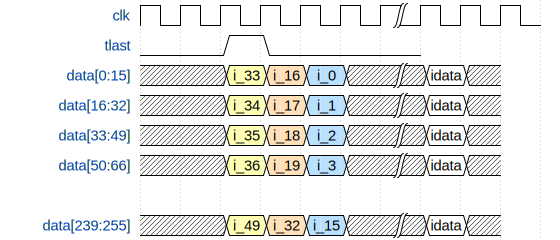

In [84]:
wd.draw({
'signal': [
  {'name': 'clk', 'wave': 'p.....|...'},
  {'name': 'tlast', 'wave': '0.10...'},
  {'name': 'data[0:15]', 'wave': 'x.345x|=x', 'data': ['i_33', 'i_16','i_0','idata']},
  {'name': 'data[16:32]', 'wave': 'x.345x|=x', 'data': ['i_34', 'i_17','i_1','idata']},
  {'name': 'data[33:49]', 'wave': 'x.345x|=x', 'data': ['i_35', 'i_18','i_2','idata']},
  {'name': 'data[50:66]', 'wave': 'x.345x|=x', 'data': ['i_36', 'i_19','i_3','idata']},
  {},
  {'name': 'data[239:255]', 'wave': 'x.345x|=x', 'data': ['i_49', 'i_32','i_15','idata']},
]})

The core is programmed over AXI4-Lite using the DAC Replay Python driver availbale [here](https://github.com/MazinLab/MKIDGen3/blob/develop/mkidgen3/drivers/dactable.py). This core is nominally used to feed two RFSoC DACs but it is also possible to stream data to other DSP logic within the FPGA fabric to test IP subsystems with data manufactured in Python. Please contact the authors to learn more about this use case.

### DAC Waveform

The following cells demonstrate how to construct an arbitrary waveform and play it out of the DACs.

In [85]:
#Set tones to send (in Hz). Domain is [-2047,2048) MHz. Set the SNR for a noise floor, `'max'` will turn off noise.
tones = np.array([300e6, 300.5e6])
amplitudes = np.ones_like(tones)/tones.shape[0]
snr = 'max'

In [86]:
Ns=2**19 # fill the DAC LUT Table
in_noise = 0
if snr != 'max':
    a_noise = 10**((20*np.log10(1/np.sqrt(2)) - snr)/10)
    in_noise = np.sqrt(a_noise)*(np.random.uniform(-1,1,size=Ns) + 1j*np.random.uniform(-1,1,size=Ns))

In [87]:
# Compute the waveform
dactable = generate_dac_comb(frequencies=tones, n_samples=Ns, sample_rate=4.096e9, amplitudes=amplitudes)
if snr != 'max':
    dactable['iq']+=in_noise
    dactable['iq']/=max(dactable['iq'].real, dactable['iq'].imag)
    pass

In [88]:
# Program URAM and run DAC Table
if ol.dac_table_axim_0.register_map.run.run:
    ol.dac_table_axim_0.stop()
ol.dac_table_axim_0.replay(dactable['iq'], fpgen='simple')

At this point, you should be able to measure the DAC output using a Spectrum Analyzer or Oscilloscope. You can also use the RFSoC ADCs! Keep scrolling to see how.

### Capture & Plot DAC Output Using RFSoC ADCs

With the ZCU111 connected in loopback, we can sample the DAC output with the RFSoC ADCs and capture the result to the PL DRAM where we can visualize it in this notebook.

In [89]:
N = Ns # Number of samples to capture (full waveform)
Fs = 4.096e9 # ADC Sample Rate [Hz]
Tc = N/Fs # total collection time (seconds)

In [90]:
# Trigger Capture
adc_capture_data = ol.capture.capture_adc(N, complex=True)
adc_capture_data/=2**16  #Normalize to 1/2 V

DEBUG:mkidgen3.drivers.capture:Capture of ddciq not supported
DEBUG:mkidgen3.drivers.capture:Capturing 2.0 MB of data @ 16384 MB/s. ETA 0 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 2097152 bytes (32768 beats) to address 0x500000000 from source adc


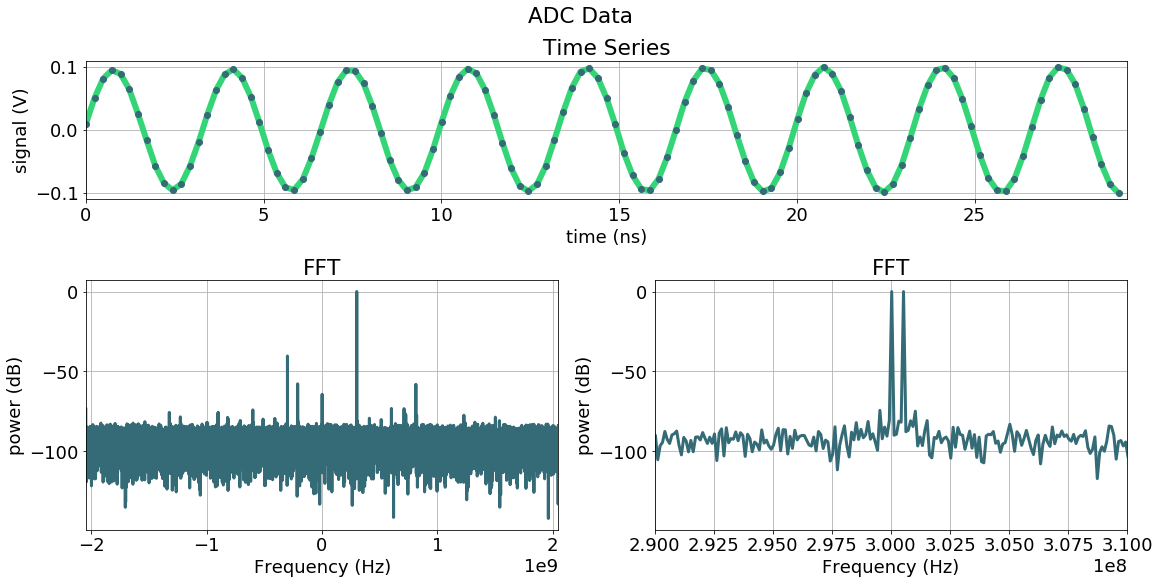

In [93]:
# Plot ADC Data
timerange = (0,120)  # ns
fftrange= (16, 16 + 20*4096) 
fftzoom = (2.9e8, 3.1e8)
mkidgen3.plotting.adc_test_plot(adc_capture_data, timerange, fftrange, fftzoom)

### QMC Correction

In the plots above, you may have noticed we generated the frequencies desired, but we also generated image tones on the other half of the spectrum. This is due to slight gain, phase, and offset imbalances in the I and Q ADCs and DACs. As is, there should be a ~40 dB offset. This is good enough for our application (and most) but it is possible to use the built-in QMC circuit to try to correct for these imbalances. The figure below is copied from [PG269 page v2.4 page 140](https://docs.xilinx.com/v/u/2.4-English/pg269-rf-data-converter).

<img src="images/qmc.png" alt="drawing" width="500"/>

In this design the I DAC is dac(1,3) and the Q DAC is dac(1,4).

In [94]:
ol.rfdc.set_qmc(dac=(1,3), gain=0.5)

INFO:mkidgen3.drivers.rfdc:RFDCHierarchy does not support switching ADCs
Setting DAC Tile 1, Block 3


{'EnableGain': 1,
 'EnablePhase': 0,
 'EventSource': 0,
 'GainCorrectionFactor': 0.5,
 'OffsetCorrectionFactor': 0,
 'PhaseCorrectionFactor': 0.0}

In [95]:
# Trigger another ADC Capture
adc_capture_data = ol.capture.capture_adc(N, complex=True)
adc_capture_data/=2**16  #Normalize to 1/2 V

DEBUG:mkidgen3.drivers.capture:Capturing 2.0 MB of data @ 16384 MB/s. ETA 0 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 2097152 bytes (32768 beats) to address 0x500200000 from source adc


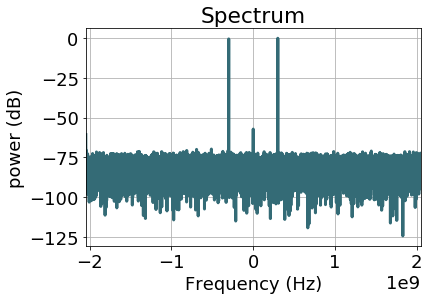

In [96]:
# Plot ADC Capture
mkidgen3.plotting.plot_adc_fft(adc_capture_data, fs=4.096e9, db=True, fft_points=2**14, xlim=(-2.048e9,2.048e9), ylim=None, ax=None)

As you may have discovered the QMC is very sensitive. It's hard to do better than 40 dB-- almost any noticable change will make it much worse!

In [97]:
# Return to Default Settings
ol.rfdc.set_qmc(dac=(1,3))

Setting DAC Tile 1, Block 3


{'EnableGain': 0,
 'EnablePhase': 0,
 'EventSource': 0,
 'GainCorrectionFactor': 0.0,
 'OffsetCorrectionFactor': 0,
 'PhaseCorrectionFactor': 0.0}

## 2.2 Oversampled Polyphase Filter Bank (OPFB) <a class="anchor" id="opfb"></a>

The OPFB is a 4,096-channel, 2/1 oversampled 4 GHz channelizer. It takes in 2, 4.096 GSPS data streams--one from and I ADC and the other from a Q ADC, and produces 4096 2 MHz channels which overlap by 50%. This overlapping feature insures that no matter where a signal exists in-band, it will be able to pass through the channelizer un-attenuated. This IP is the subject of [this publication](https://ieeexplore.ieee.org/document/9336352) and is also documented in a [stand-alone git repo](https://github.com/MazinLab/RFSoC_OPFB).

After being sampled by the ADCs, we can run the data through the OPFB IP and capture the result to the PPL DDR4 for visualization.

### OPFB Capture

<script src="https://cdnjs.cloudflare.com/ajax/libs/wavedrom/2.6.8/skins/default.js" type="text/javascript"></script>
<body onload="WaveDrom.ProcessAll()">
<script type="WaveDrom">
{ signal : [
  { name: "clk",  wave: "p......" },
  { name: "bus",  wave: "x.34.5x",   data: "head body tail" },
  { name: "wire", wave: "0.1..0." },
]}
</script>

In [98]:
# Capture N samples from all 4096 OPFB Bins
opfb_raw = g3.capture_opfb(1024, raw=True)
# Convert to complex numbers
opfb_fp = opfb_raw[..., 0] + 1j*(opfb_raw[..., 1])

DEBUG:mkidgen3.drivers.capture:Capturing 8.0 MB of data @ 16384.0 MBps. ETA 0 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 8388608 bytes (131072 beats) to address 0x500400000 from source rawiq
DEBUG:mkidgen3.drivers.capture:Capturing 8.0 MB of data @ 16384.0 MBps. ETA 0 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 8388608 bytes (131072 beats) to address 0x500c00000 from source rawiq


In [99]:
# Bin Offset Correction (Author's are working to fix)
opfb_shifted = np.roll(opfb_fp, 16, axis=1)

### Plot OPFB

In [100]:
all_bins = np.linspace(0,4095,4096).astype(int).tolist()

/home/xilinx/src/mkidgen3/mkidgen3/dsp.py:21: RuntimeWarning: divide by zero encountered in log10
  x = 20 * np.log10(np.abs(np.fft.fft(data, axis=0)))


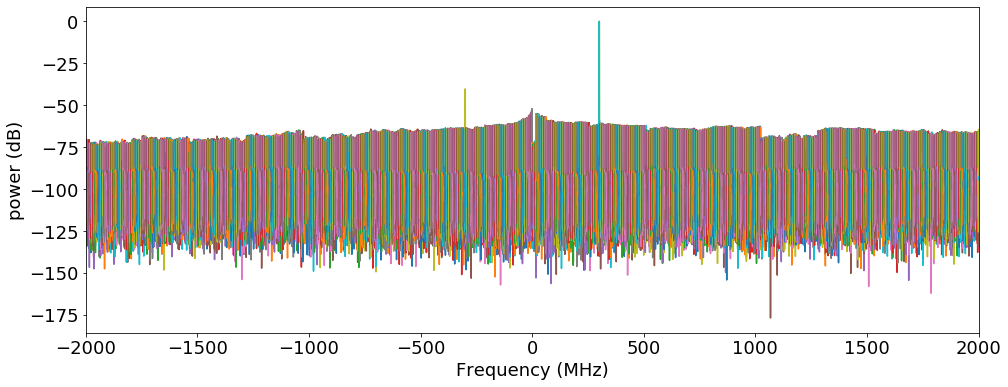

In [101]:
mkidgen3.plotting.plot_opfb_bins(opfb_shifted,all_bins);

We expect our 300 MHz tone to be in bin 2348. Because the channelizer is 50% overlapping, we also expect to see the 300.5 MHz tone in that bin as well as the neighboring bin with equal magnitude in each bin. Indeed we see that is the case below.

In [102]:
g3.opfb_bin_number(300e6,ssr_raw_order=False)

2348

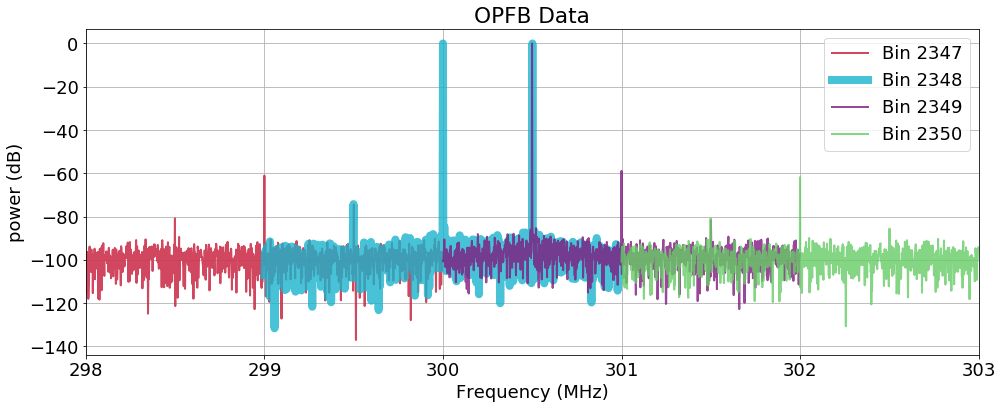

In [103]:
mkidgen3.fccm22_demo.plot_fccm_demo_bins(opfb_shifted)

## 2.3 Bin Select (bin2res) <a class="anchor" id="binselect"></a>

The bin select block is a Vitis HLS IP. The source code along with the exported IP is available [here](https://github.com/MazinLab/opfb-bin-to-res/tree/2021.1). The bin select block caches 8 full spectra from the 4,096-bin opfb channelizer and assigns up to 2048 output bins to user defined channels. The user programs the core over AXI4-Lite to tell it which of the 4096 input OPFB bins to map to which of the 2048 output channels with arbitrary mapping. An example of how we might program the bin select block is shown in the figure below.

<img src="images/Bin_Select_Notebookl.png" alt="drawing" width="600"/>

In the previous cells, we implicitly used the bin select block to capture the OPFB. We programmed bin select to route the first 2048 bins to 2048 corresponding resonator channels and subsequently capture the resonator channels. Then we reprogram bin select to route the second 2048 bins to 2048 corresponding resonator channels and capture the result. Now we will do some experimenting with the bin select block and show how you can arbitrarily assign opfb bins to resonator channels.

Nominally, the 300 MHz tone we generated will be output in bin 300 from the SSR FFT:

In [104]:
g3.opfb_bin_number(300e6,ssr_raw_order=True)

300

We can see it if we quickly plot the average value of the real signal in each opfb bin:

peak in bin: 300


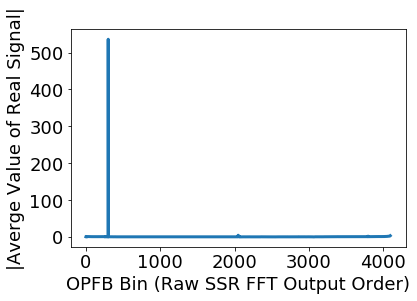

In [105]:
mkidgen3.plotting.find_opfb_tones(opfb_shifted)

Now we will assign that bin with the tone to every 256th resonator channel. Note there is currently a 16-bin shift in the output of the OPFB FFT. The author's are working to fix this but for now it can be corrected in software easily enough.

In [106]:
n = 256
bins = np.zeros(2048, dtype=int)
bins[::256] = 300-16
ol.photon_pipe.reschan.bin_to_res.bins = bins

Now we will capture the bin select output:

In [107]:
out = np.zeros((n, 4096, 2))
x = ol.capture.capture_iq(n, 'all', tap_location='rawiq')
out[:, :2048, :] = x
x.freebuffer()

DEBUG:mkidgen3.drivers.capture:Capturing 2.0 MB of data @ 16384.0 MBps. ETA 0 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 2097152 bytes (32768 beats) to address 0x501400000 from source rawiq


In [108]:
# Convert data back to float
cap_out = out[..., 0] + 1j*(out[..., 1])

We can see now that we have placed the bin with the tone in every 256th resonator channel as desired.

peak in bin: 2033


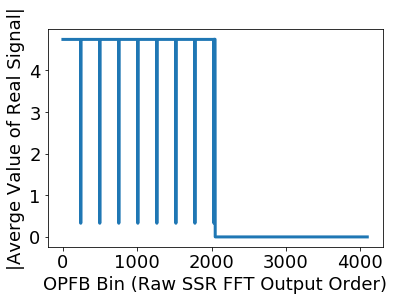

In [109]:
mkidgen3.plotting.find_opfb_tones(cap_out)

## 2.4 Capture Subsystem <a class="anchor" id="capture"></a>

The capture subsystem is responsible for streaming data to the PL DDR4 from four different locations in the DSP pipeline. These four location are shown explicitly in the [System Overview](#system) block design. The capture system uses four Vitis HLS IP ([source code](https://github.com/Mazinlab/iq-capture/tree/master)) to manipulate data streams from each of the four locations. These streams are then multiplexed by an AXIS Switch with AXI-Lite control. We use an [open-source RTL core](https://github.com/MazinLab/wb2axip/tree/master) to translate AXIS to AXI burst transactions. We use a modified version of an AXI Interconnect (JebConnect) to route the data to the PL DDR4. The capture driver source is avilable [here](https://github.com/MazinLab/MKIDGen3/blob/develop/mkidgen3/drivers/capture.py). 

<img src="images/capture.png" alt="capture" width="1000"/>